# Final Project 1: Melanoma Classification

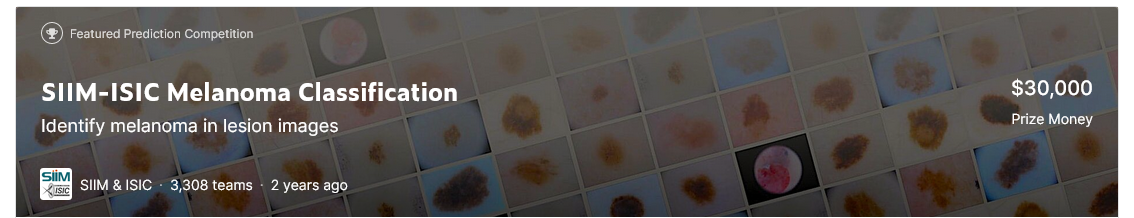


for this project we use <a href='https://www.kaggle.com/competitions/siim-isic-melanoma-classification'>SIIM-ISIC Melanoma Classification</a> dataset.

## Perform standard imports

In [3]:
# System
import cv2
import os, os.path
from PIL import Image             
import gc
import time
import datetime

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm     

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from skimage import io

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision.models import resnet34
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ! pip install pydicom

In [ ]:
from pydicom.data import get_testdata_file
import pydicom


In [ ]:
import glob
dir_data = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/'
paths_test = glob.glob(dir_data+ 'test/*.dicom')
paths_train = glob.glob(dir_data+ 'train/*.dicom')

In [4]:
def get_image_id(path):
    return path.split('/')[-1].split('.')[0]
dicom_data = paths_train[1]
df_train = pd.read_csv(dir_data + 'train.csv')
display(df_train['image_id'][0])
dicom = pydicom.read_file(dicom_data)
image = dicom.pixel_array
plt.figure(figsize = (12,12))
plt.imshow(image, 'gray');


In [5]:
dicom = pydicom.read_file(paths_train[1])
# pixel_array = np.frombuffer(dicom.pixel_array, dtype=np.int16)
pixel_array = dicom.pixel_array.astype(np.float32)
# pixel_array = np.reshape(pixel_array, (3072,3072))


In [6]:
transformer = transforms.Compose([
                                                    transforms.ToPILImage(),
                                                    transforms.Resize(224),
#     transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                                                  transforms.RandomResizedCrop((224,224), scale=(0.4, 1.0)),
#                                                  transforms.RandomHorizontalFlip(p = 0.3),
#                                                  transforms.RandomVerticalFlip(p = 0.3),
#                                                  transforms.ToTensor(),
#                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                 ])
dicom = pydicom.read_file(paths_train[5])
# pixel_array = np.frombuffer(dicom.pixel_array, dtype=np.int16)
pixel_array = dicom.pixel_array
new_image = ((np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0).astype(np.uint8)
new_image = np.stack([new_image,new_image,new_image], axis=-1)
# pixel_array = np.reshape(pixel_array, (3072,3072))
print(new_image.shape)
# print(dicom.pixel_array.shape)
image = new_image
# plt.figure(figsize = (12,12))

timg = transformer(new_image)
# new = timg.transpose((1,2))

plt.imshow(image, 'gray')

In [7]:
image = dicom.pixel_array
image
print("Shape of the extracted DICOM image:", image.shape)
print("Minimum pixel value:", image.min())
print("Maximum pixel value:", image.max())

In [8]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


In [9]:
# For reproducibility
seed = 1234

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

In [11]:
train_df = pd.read_csv(dir_data + 'train.csv')
train_df.info()

In [12]:
train_df.class_name.value_counts()

In [13]:
len(train_df)

## Create DataSet

In [24]:
class XrayDataset(Dataset):
    
    def __init__(self, dataframe,is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid = dataframe[:100], is_train, is_valid
        
        # Data Augmentation
        if is_train or is_test:
            self.transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(224),
                                                 transforms.RandomResizedCrop((224,224), scale=(0.4, 1.0)),
                                                 transforms.RandomHorizontalFlip(p = 0.3),
                                                 transforms.RandomVerticalFlip(p = 0.3),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        else:
            self.transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224,224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Select path and read image
        item = self.dataframe.iloc[[index]]
        img_name = item['image_id'].values[0]
        dicom_path = f'/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/{img_name}.dicom'
        dicom = pydicom.read_file(dicom_path)
        pixel_array = dicom.pixel_array
        new_image = ((np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0).astype(np.uint8)
        new_image = np.stack([new_image,new_image,new_image], axis=-1)
#         pixel_array = np.frombuffer(dicom, dtype=np.int16)
#         pixel_array = np.reshape(pixel_array, (512,512))
        image = new_image
        
        # Apply transforms
        image = self.transform(image)

#         print(self.dataframe['class_id'][index])
        # If train/valid: image + class | If test: only image
        if self.is_train or self.is_valid:
            one_hot = F.one_hot(torch.tensor(item['class_id'].values[0]),num_classes=15)
#             print(f"one-hot {one_hot}")
#             return (image, self.dataframe['class_id'])
            return (image, one_hot)
        else:
            return (image)

In [25]:
F.one_hot(torch.tensor(train_df[train_df['class_id']==9]['class_id'].values),num_classes=15).shape

## Create Model

In [26]:
print(resnet34(pretrained=True))

In [28]:
class ResNet34Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define Feature part (IMAGE)
        self.features = resnet34(pretrained=True) # 1000 neurons out
        
        for param in self.features.parameters():
            param.requires_grad = False
  
        # Define Classification part
        self.classification = nn.Linear(1000, 15)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, image):
        # Image CNN
        image = self.features(image)
        
        # Classifier
        out = self.classification(image)
        out = self.softmax(out)
        
        return out

In [29]:
model = ResNet34Network()
model = model.to(device)

In [30]:
print(model)

In [32]:
# Data object and Loader
dataset = XrayDataset(train_df, is_train=True, is_valid=False, is_test=False)
loader = DataLoader(dataset,batch_size=3, shuffle=True)

In [35]:
# Get a sample
for image, labels in loader:
    plt.subplot(1, 3,1)
    plt.imshow(image[0,0,:,:], 'gray')
    plt.subplot(1, 3,2)
    plt.imshow(image[1,0,:,:], 'gray')
    plt.subplot(1, 3,3)
    plt.imshow(image[2,0,:,:], 'gray')
    display(labels)
    model.cpu()
    print(f"out: {model(image)}")
    image_example = image
    labels_example = torch.tensor(labels, dtype=torch.float32)
    break
    
print('Data shape:', image_example.shape)
print('Label:', labels_example)

In [36]:
learning_rate = 0.0005
epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [37]:
# Initiate the model
model = model
model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = learning_rate)
# criterion = nn.BCEWithLogitsLoss()  
criterion = nn.CrossEntropyLoss()

In [ ]:
train_size = int(len(train_df) * 0.6)
val_size = int(len(train_df) * 0.2)
test_size = int(len(train_df) * 0.2)

print(f'train size : {train_size}, val size : {val_size}, test size : {test_size}')

In [ ]:
# --- Read in Data ---
train_data = train_df.iloc[:train_size].reset_index(drop=True)
valid_data = train_df.iloc[train_size:train_size + val_size].reset_index(drop=True)
test_data = train_df.iloc[train_size + val_size:].reset_index(drop=True)
# Create Data instances
train = XrayDataset(train_data, is_train=True, is_valid=False, is_test=False)
valid = XrayDataset(valid_data, is_train=False, is_valid=True, is_test=False)
test = XrayDataset(valid_data, is_train=False, is_valid=True, is_test=False)

# Dataloaders
train_loader = DataLoader(train, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=8, shuffle=True)
test_loader = DataLoader(valid, batch_size=1, shuffle=True)

In [ ]:
labels = torch.arange(14)
labels = labels.reshape(14, 1)

num_classes = 14
one_hot_target = (labels == torch.arange(num_classes).reshape(1, num_classes)).float()
one_hot_target
one_hot = F.one_hot(torch.tensor(train_df['class_id'].values[0]))
display(train_df.shape)
one_hot
# type(train_df['class_id'])
# one_hotYt_train.type(torch.LongTensor)
# type(one_hot[0].type(torch.LongTensor))

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
display(input,target)
display(type(input),type(target))

In [ ]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()
display(input,target)

In [ ]:
# === EPOCHS ===
for epoch in range(epochs):
    print(f'epoch : {epoch} start!')
    start_time = time.time()
    correct = 0
    train_losses = 0

    # === TRAIN ===
    # Sets the module in training mode.
    model.train()

    for images, labels in train_loader:
        # Save them to device
        images = torch.tensor(images, device=device, dtype=torch.float32)
        labels = torch.tensor(labels, device=device, dtype=torch.float32)
#         print("labels")
#         print(labels)
#         print(type(labels))
        # Clear gradients first; very important, usually done BEFORE prediction
        optimizer.zero_grad()
        

        # Log Probabilities & Backpropagation
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        train_losses += loss.item()
        # From log probabilities to actual probabilities
        train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
        # Number of correct predictions
        correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()
        print(correct)
    # Compute Train Accuracy
    train_acc = correct*100 / train_size
    print(f'Epoch :{epoch + 1} - train accuracy: {train_acc}')
    
    # === EVAL ===
    model.eval()

    # Create matrix to store evaluation predictions (for accuracy)
    valid_preds = torch.zeros(size = (len(valid_data), 1), device=device, dtype=torch.float32)


    # Disables gradients (we need to be sure no optimization happens)
    with torch.no_grad():
        for k, (images, labels) in enumerate(valid_loader):
            images = torch.tensor(images, device=device, dtype=torch.float32)
            labels = torch.tensor(labels, device=device, dtype=torch.float32)

            out = model(images)
            pred = torch.sigmoid(out)
            valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

        # Compute accuracy
        valid_acc = accuracy_score(valid_data['target'].values, 
                                           torch.round(valid_preds.cpu()))*100
        # Compute ROC
        valid_roc = roc_auc_score(valid_data['target'].values, 
                                          valid_preds.cpu())

        # Compute time on Train + Eval
        duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]


        # PRINT INFO
        print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                    format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))

In [1]:
torch.save(model.state_dict(), './model.pt')

In [ ]:
# Data object and Loader
dataset = XrayDataset(train_df, is_train=True, is_valid=False, is_test=False)
loader = DataLoader(dataset,batch_size=1, shuffle=True)

In [ ]:
# Get a sample
for image, label in test_loader:
    image = torch.tensor(image, device=device, dtype=torch.float32)
    label = torch.tensor(label, device=device, dtype=torch.float32)
    out = model(image)
#     print(out)
#     loss = criterion(out, label.unsqueeze(0))
    pred = torch.sigmoid(out)
#     print('loss: ', loss)
    print('Label:', label)
    print('Pred:', pred)
    break